In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import check_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops.distributions import bijector

from tensorflow.contrib.distributions import Normal
from tensorflow.python.ops import nn
from pymisca.transformed_distribution import TransformedDistribution
# array_ops.gather_nd?

/home/shouldsee/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


is in ipython: 1
is in ipython: 1
is in ipython: 1
[WARN] pymisca.vis_util cannot find network
[WARN] pymisca.vis_util cannot find network


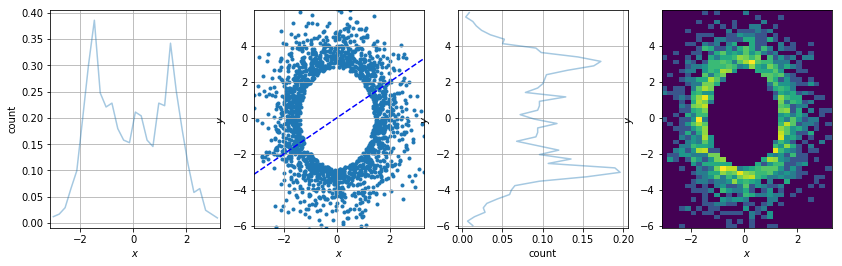

In [2]:
#### Adapted from: http://kyleclo.github.io/maximum-likelihood-in-tensorflow-pt-1/

import numpy as np
import pymisca.util as pyutil;reload(pyutil)
import pymisca.vis_util as pyvis;reload(pyvis)
%matplotlib inline 


D = 2


TRUE_MU = 0.0
TRUE_SIGMA = 2.0
SAMPLE_SIZE = (5000,D)

np.random.seed(0)
x_obs = np.random.normal(loc=TRUE_MU, scale=TRUE_SIGMA, size=SAMPLE_SIZE)
rsq = np.square(x_obs).sum(axis=-1)

keep = rsq > np.mean(rsq)
x_obs = x_obs[keep]

#### Random Linear transformation
# C = pyutil.random_covmat()
# x_obs = x_obs.dot(C)

#### Make an ellipse
x_obs.T[0] *= 0.5

# x_obs = np.square(x_obs)
pyvis.qc_2var(x_obs.T[0],x_obs.T[1])

In [3]:
import pymisca.tensorflow_extra as pytf
reload(pytf)




from tensorflow.python.ops import nn
import tensorflow as tf

# data
x = tf.placeholder(dtype=tf.float32)

INIT_MU_PARAMS = {'loc': 0.0, 'scale': 0.1}
INIT_PHI_PARAMS = {'loc': 1.0, 'scale': 0.1}
RANDOM_SEED = 0

# params
np.random.seed(RANDOM_SEED)
mu = 1. + nn.softplus(tf.Variable(initial_value=np.random.normal(**INIT_MU_PARAMS),
                 dtype=tf.float32)
                )
phi =nn.softplus( tf.Variable(initial_value=np.random.normal(**INIT_PHI_PARAMS),
                  dtype=tf.float32)
                )
sigma =nn.softplus( tf.Variable(initial_value=np.random.normal(size=(D,),
                                                               **INIT_PHI_PARAMS),
                  dtype=tf.float32)
                )

# sigma = tf.square(phi)

# loss

def makeEMD( (mu,phi,sigma) ):
    dist_rsq = tf.contrib.distributions.Gamma(concentration=mu,rate=phi)

    #### Use a bijector to calculate P(x) from P(r^2)
    dist_xyz = mdl = pytf.AsRadial(distribution=dist_rsq,
                                   D=D)
    
    ### Allow an affine transformation y = M x + x_0
    dist_aff = mdl = pytf.AffineTransformDiag(distribution=dist_xyz,
                                        scale_diag=sigma,)
    
    
    # gaussian_dist = tf.contrib.distributions.Normal(loc=mu, scale=sigma)
    # mdl  = dist_rsq
    return mdl


fitted_vars = [mu,phi,sigma]
emission = makeEMD(fitted_vars)



Xmd = np.random.random((100,200,D)).astype(np.float32)
bjt = emission.bijector
# bjt = emission.distribution.bijector
xTheta = bjt.inverse(Xmd)
print (xTheta.shape)

fldj =val= bjt.forward_log_det_jacobian(xTheta,event_ndims=1)
print (val.shape)

ildj = bjt.inverse_log_det_jacobian(Xmd,event_ndims=1,)
print (val.shape)


# assert 0

[WARN]unable to import edward.models
[WARN]unable to import edward.models
(100, 200, 2)
()
()


In [4]:
from tensorflow_probability.python import bijectors
bijectors.Bijector

tensorflow.python.ops.distributions.bijector_impl.Bijector

In [5]:
from tensorflow_probability import bijectors
# bijectors.AffineLinearOperator.inverse_log_det_jacobian?

In [6]:
fitted_vars = [mu,phi,sigma]
emission = makeEMD(fitted_vars)
log_prob = emission.log_prob(value=x)
neg_log_likelihood = -1.0 * tf.reduce_sum(log_prob)


# gradient
free_vars = [mu,phi,sigma]
grad = tf.gradients(neg_log_likelihood, free_vars)

In [7]:
#### Adapted from: http://kyleclo.github.io/maximum-likelihood-in-tensorflow-pt-1/
reload(pytf)
LEARNING_RATE = 0.1
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
sess,last_vars, hist_loss, opt = pytf.op_minimise(
    neg_log_likelihood,
    fitted_vars,
    optimizer,
    feed_dict = {x: x_obs}
)

[WARN]unable to import edward.models
Iter 0 10456.869
Iter 100 6946.652
Iter 200 6910.7188
Loss function convergence in 283 iterations!: 6909.80615234


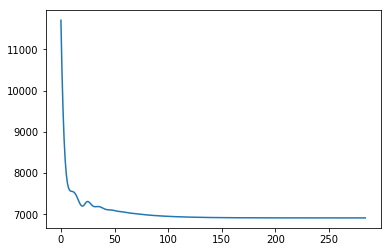

In [8]:
import pymisca.vis_util as pyvis
%matplotlib inline 

plt = pyvis.plt
plt.plot(hist_loss)

In [9]:
print (last_vars)

[5.3559785, 1.3342365, array([0.98251045, 1.9590445 ], dtype=float32)]


In [10]:
with sess.as_default():
    print ([x.eval() for x in emission.distribution._graph_parents])

[5.3559785, 1.3342365]


Instructions for updating:
dim is deprecated, use axis instead


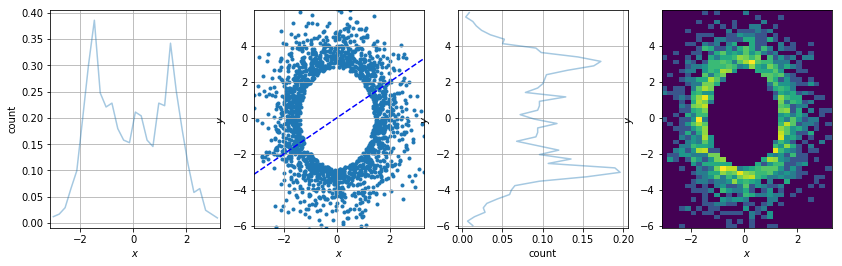

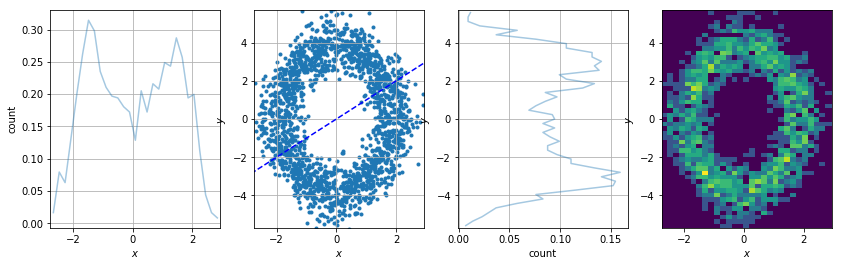

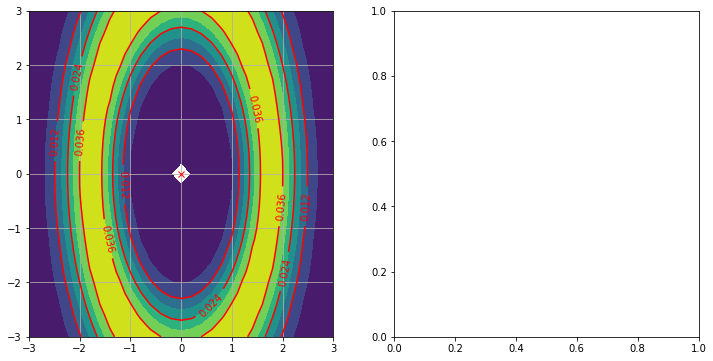

In [11]:
with sess.as_default():
# sess = tf.InteractiveSession()
# if 1:
    EMD = makeEMD(last_vars)
    X = x_obs.astype(np.float32)
    Y = EMD.sample(len(X)).eval()
    L = EMD.log_prob(X).eval()
    pyvis.qc_2var(X.T[0],X.T[1])
    pyvis.qc_2var(Y.T[0],Y.T[1])
    
    f = EMD.prob
    L = f(X).eval()
#     f = emission.distribution.distribution.prob
    f = pyutil.wrapTFmethod(f,sess=sess)
    f = pyutil.arrayFunc2mgridFunc(f)
    pyvis.dmet_2d(f,vectorised=1,span=[-3,3]);
    
#     Z = EMD.bijector.inverse(X).eval()
#     pyvis.qc_2var(Z.T[0],Z.T[1])

(array([ 20.,  18.,  12.,   7.,  11.,   4.,   6.,  13.,   5.,   6.,   9.,
          4.,   8.,   4.,   8.,   6.,  10.,   6.,   5.,   9.,   4.,   7.,
          6.,   8.,   7.,   7.,   3.,   3.,   5.,   4.,   3.,   8.,   9.,
          7.,   9.,  10.,   1.,   3.,   5.,   7.,   5.,   5.,   5.,   5.,
          3.,   7.,   4.,   6.,   4.,   8.,   5.,   4.,  11.,  11.,   6.,
          6.,   7.,   7.,   6.,   7.,   3.,   7.,   6.,   4.,   6.,  24.,
         19.,  27.,  31.,  23.,  17.,  22.,  30.,  21.,  21.,  27.,  33.,
         27.,  20.,  27.,  27.,  28.,  26.,  39.,  38.,  36.,  28.,  36.,
         37.,  32.,  47.,  34.,  44.,  42.,  47.,  50.,  65.,  57., 115.,
        235.]),
 array([1.19418084e-08, 4.13796878e-04, 8.27581814e-04, 1.24136675e-03,
        1.65515169e-03, 2.06893662e-03, 2.48272156e-03, 2.89650649e-03,
        3.31029143e-03, 3.72407636e-03, 4.13786130e-03, 4.55164624e-03,
        4.96543117e-03, 5.37921611e-03, 5.79300104e-03, 6.20678598e-03,
        6.62057092e-03, 7.0343

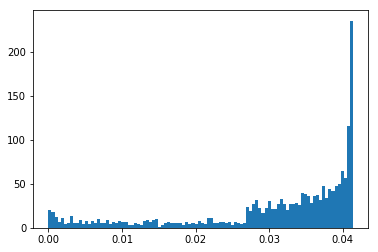

In [12]:
plt.hist(L.ravel(),100)

In [ ]:
with sess.as_default():
#     emission.distribution.p
    Y = EMD.sample(len(X)).eval()

    pyvis.qc_2var(X.T[0],X.T[1])
    pyvis.qc_2var(Y.T[0],Y.T[1])
    f = EMD.prob
    L = f(X).eval()
#     f = emission.distribution.distribution.prob
    f = pyutil.wrapTFmethod(f,sess=sess)
    f = pyutil.arrayFunc2mgridFunc(f)
    pyvis.dmet_2d(f,vectorised=1);

In [ ]:
bijectors.AffineLinearOperator

In [ ]:
# from tensorflow_probability.python import bijectors
# bijectors.Affine??

In [ ]:
from tensorflow_probability.python import bijectors